## Alivia / Vaia

For our section of the notebook we will be running a logistic regression model using SMOTE

In [49]:
import pandas as pd
import numpy as np
np.random.seed(42)
from pandas import get_dummies
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold,\
cross_val_score, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc,\
classification_report, make_scorer, recall_score, mean_squared_error
from sklearn.metrics import roc_auc_score as ras
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,\
StandardScaler, MinMaxScaler, normalize
from sklearn.neighbors import KNeighborsRegressor
from imblearn.over_sampling import SMOTE, RandomOverSampler
import warnings
warnings.filterwarnings('ignore')

In [50]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [51]:
df.drop("id", axis=1, inplace=True)

In [52]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [53]:
# LabelEncoder
df = df[df["gender"]!="Other"]
df["gender"].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [54]:
df.shape

(5109, 11)

(array([1025., 1291., 1565., 1228.]),
 array([8.000e-02, 2.056e+01, 4.104e+01, 6.152e+01, 8.200e+01]),
 <BarContainer object of 4 artists>)

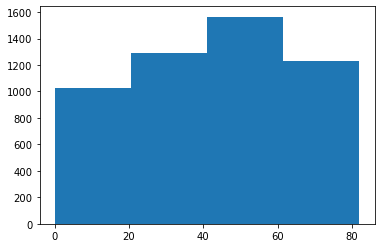

In [55]:
plt.hist(df["age"], bins=4)

In [56]:
df["ever_married"].value_counts()

Yes    3353
No     1756
Name: ever_married, dtype: int64

In [57]:
df["Residence_type"].value_counts()

Urban    2596
Rural    2513
Name: Residence_type, dtype: int64

In [58]:
df["work_type"].value_counts()

Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [59]:
df["smoking_status"].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

In [60]:
df.select_dtypes(include=['object']).head()

,gender,ever_married,work_type,Residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked


In [61]:
categorical = df.select_dtypes(include=['object'])

ohe = OneHotEncoder(drop='first')
ohe.fit(categorical)
categorical_encoded = pd.DataFrame(ohe.transform(categorical).todense(),
                               columns=ohe.get_feature_names_out())
categorical_encoded

,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
5104,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
5105,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5106,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5107,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [62]:
df_numeric = df.select_dtypes("number")
df_numeric.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,67.0,0,1,228.69,36.6,1
1,61.0,0,0,202.21,NaN,1
2,80.0,0,1,105.92,32.5,1
3,49.0,0,0,171.23,34.4,1
4,79.0,1,0,174.12,24.0,1


In [63]:
df_new = pd.concat([categorical_encoded.reset_index(), df_numeric.reset_index()], axis=1)
df_new.drop("index", axis=1, inplace=True)
df_new.head()

,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,67.0,0,1,228.69,36.6,1
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,61.0,0,0,202.21,NaN,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,80.0,0,1,105.92,32.5,1
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,49.0,0,0,171.23,34.4,1
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,79.0,1,0,174.12,24.0,1


In [64]:
# Split the data into features and target
X = df_new.drop('bmi', axis=1)
y = df_new['bmi']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the KNNImputer and grid search
param_grid = {'n_neighbors': [1, 2, 3, 4, 5]}
knn_imputer = KNNImputer()

# Create a custom scorer using mean_squared_error
custom_scorer = make_scorer(mean_squared_error, greater_is_better=False)

grid_search = GridSearchCV(knn_imputer, param_grid, cv=5, scoring=custom_scorer)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters, including the best number of neighbors (k)
best_params = grid_search.best_params_
best_neighbors = best_params['n_neighbors']

# Print the best parameters
print("Best Parameters:")
print(best_params)

Best Parameters:
{'n_neighbors': 1}


In [65]:
knn_imputer = KNNImputer(n_neighbors=1)  # Adjust the number of neighbors as needed

# Impute missing values in the DataFrame
df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_new), columns=df_new.columns)

In [66]:
# Handling multicollinearity

columns = list(df_imputed.columns)
for col in columns:
    if col == 'stroke':
        continue

    filtered_columns = [col]
    for col1 in df_imputed.columns:
        if((col == col1) | (col == 'stroke')):
            continue

        val = df_imputed[col].corr(df_imputed[col1])

        if val > 0.7:
            # If the correlation between the two
            # features is more than 0.7 remove
            columns.remove(col1)
            continue
        else:
            filtered_columns.append(col1)

    # After each iteration filter out the columns
    # which are not highly correlated features.
    df = df_imputed[filtered_columns]
df.shape

(5109, 16)

# Model
We worked on the logistic regression, specifically optimizing accuracy scores without causing overfitting via testing different class weights and experimenting with recall threshold

In [68]:
features = df.drop('stroke', axis=1)
target = df['stroke']
 
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)

X_train.shape, X_val.shape

((4087, 15), (1022, 15))

## Class Weights
Below we implemented a balanced class weight, which is important for our dataset as we have outliers, such as individuals that are much younger than the rest of the group in the study. Class weights ensure that our model takes into account outliers while training, which in this case would be 'healthy' patients with zero comorbidities testing positive for a stroke.

In [80]:
recall_scores = []

smote = SMOTE(random_state=0)
ros = RandomOverSampler(sampling_strategy='minority', random_state=0)

oversampling_techniques = [smote, ros]

for technique in oversampling_techniques:
    
    print(f'{technique} : ')
    print("___________________________________________")
    
    X_resampled, Y_resampled = technique.fit_resample(X_train, Y_train)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_resampled)
    X_val_scaled = scaler.transform(X_val)

    X_train_scaled.shape, Y_resampled.shape

    models = [DecisionTreeClassifier(), 
              RandomForestClassifier(), 
              KNeighborsClassifier(), 
              SVC(kernel='rbf', probability=True),
              XGBClassifier()]

    # logistic Regression with class weights
    logreg = LogisticRegression(class_weight='balanced')  

    models.append(logreg)

    for model in models:
        model.fit(X_train_scaled, Y_resampled)

        print(f'{model} : ')

        train_preds_proba = model.predict_proba(X_train_scaled)[:, 1]
        print('Training ROC AUC Score : ', ras(Y_resampled, train_preds_proba))

        val_preds_proba = model.predict_proba(X_val_scaled)[:, 1]
        print('Validation ROC AUC Score : ', ras(Y_val, val_preds_proba))
        print()

        train_preds = model.predict(X_train_scaled)
        print('Training Accuracy : ', ras(Y_resampled, train_preds))

        val_preds = model.predict(X_val_scaled)
        print('Validation Accuracy : ', ras(Y_val, val_preds))
        print()

        conf_matrix = confusion_matrix(Y_val, val_preds, normalize='true')

        print("Confusion Matrix:")
        print(conf_matrix)

        test_recall = recall_score(Y_val, val_preds)
        recall_scores.append(test_recall)
        print(f"Recall: {test_recall}")

        print("")
        print("----------------------")
        print("")


SMOTE(random_state=0) : 
___________________________________________
DecisionTreeClassifier() : 
Training ROC AUC Score :  1.0
Validation ROC AUC Score :  0.5632510288065844

Training Accuracy :  1.0
Validation Accuracy :  0.5632510288065844

Confusion Matrix:
[[0.94650206 0.05349794]
 [0.82       0.18      ]]
Recall: 0.18

----------------------

RandomForestClassifier() : 
Training ROC AUC Score :  1.0
Validation ROC AUC Score :  0.7660493827160493

Training Accuracy :  0.9998713991769548
Validation Accuracy :  0.5279423868312758

Confusion Matrix:
[[0.99588477 0.00411523]
 [0.94       0.06      ]]
Recall: 0.06

----------------------

KNeighborsClassifier() : 
Training ROC AUC Score :  0.9982494014504903
Validation ROC AUC Score :  0.6308333333333334

Training Accuracy :  0.958204732510288
Validation Accuracy :  0.5929012345679012

Confusion Matrix:
[[0.88580247 0.11419753]
 [0.7        0.3       ]]
Recall: 0.3

----------------------

SVC(probability=True) : 
Training ROC AUC Score

In [81]:
#updated code to store recall scores in list

recall_scores = []

smote = SMOTE(random_state=0)
ros = RandomOverSampler(sampling_strategy='minority', random_state=0)

oversampling_techniques = [smote, ros]

for technique in oversampling_techniques:
    
    print(f'{technique} : ')
    print("___________________________________________")
    
    X_resampled, Y_resampled = technique.fit_resample(X_train, Y_train)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_resampled)
    X_val_scaled = scaler.transform(X_val)

    X_train_scaled.shape, Y_resampled.shape

    models = [DecisionTreeClassifier(), 
              RandomForestClassifier(), 
              KNeighborsClassifier(), 
              SVC(kernel='rbf', probability=True),
              XGBClassifier()]

    # Logistic Regression with class weights
    logreg = LogisticRegression(class_weight='balanced')  

    models.append(logreg)

    for model in models:
        model.fit(X_train_scaled, Y_resampled)

        print(f'{model} : ')

        train_preds_proba = model.predict_proba(X_train_scaled)[:, 1]
        print('Training ROC AUC Score : ', ras(Y_resampled, train_preds_proba))

        val_preds_proba = model.predict_proba(X_val_scaled)[:, 1]
        print('Validation ROC AUC Score : ', ras(Y_val, val_preds_proba))
        print()

        train_preds = model.predict(X_train_scaled)
        print('Training Accuracy : ', ras(Y_resampled, train_preds))

        val_preds = model.predict(X_val_scaled)
        print('Validation Accuracy : ', ras(Y_val, val_preds))
        print()

        conf_matrix = confusion_matrix(Y_val, val_preds, normalize='true')

        print("Confusion Matrix:")
        print(conf_matrix)

        test_recall = recall_score(Y_val, val_preds)
        recall_scores.append(test_recall)
        print(f"Recall: {test_recall}")

        print("")
        print("----------------------")
        print("")

print("Recall Scores for Each Model:")
print(recall_scores)


SMOTE(random_state=0) : 
___________________________________________
DecisionTreeClassifier() : 
Training ROC AUC Score :  1.0
Validation ROC AUC Score :  0.5647942386831275

Training Accuracy :  1.0
Validation Accuracy :  0.5647942386831275

Confusion Matrix:
[[0.94958848 0.05041152]
 [0.82       0.18      ]]
Recall: 0.18

----------------------

RandomForestClassifier() : 
Training ROC AUC Score :  1.0
Validation ROC AUC Score :  0.7725

Training Accuracy :  1.0
Validation Accuracy :  0.5274279835390947

Confusion Matrix:
[[0.99485597 0.00514403]
 [0.94       0.06      ]]
Recall: 0.06

----------------------

KNeighborsClassifier() : 
Training ROC AUC Score :  0.9982494014504903
Validation ROC AUC Score :  0.6308333333333334

Training Accuracy :  0.958204732510288
Validation Accuracy :  0.5929012345679012

Confusion Matrix:
[[0.88580247 0.11419753]
 [0.7        0.3       ]]
Recall: 0.3

----------------------

SVC(probability=True) : 
Training ROC AUC Score :  0.9887972740330064
Vali

## Recall Threshold Analysis
The following code assesses the impact of setting a recall threshold to different percentages. The higher the threshold, the greater probability of possibly reducing false positives. However, if too high this can result in missing some true positives. Alternatively, too low of a threshold can result in more predicted positives and increase the odds of a false positive.

In [82]:
#recall threshold of 90%
from sklearn.metrics import precision_recall_curve

recall_scores = []

smote = SMOTE(random_state=0)
ros = RandomOverSampler(sampling_strategy='minority', random_state=0)

oversampling_techniques = [smote, ros]

for technique in oversampling_techniques:
    
    print(f'{technique} : ')
    print("___________________________________________")
    
    X_resampled, Y_resampled = technique.fit_resample(X_train, Y_train)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_resampled)
    X_val_scaled = scaler.transform(X_val)

    X_train_scaled.shape, Y_resampled.shape

    models = [DecisionTreeClassifier(), 
              RandomForestClassifier(), 
              KNeighborsClassifier(), 
              SVC(kernel='rbf', probability=True),
              XGBClassifier()]

    # Logistic Regression with class weights
    logreg = LogisticRegression(class_weight='balanced')  

    models.append(logreg)

    for model in models:
        model.fit(X_train_scaled, Y_resampled)

        print(f'{model} : ')

        train_preds_proba = model.predict_proba(X_train_scaled)[:, 1]
        print('Training ROC AUC Score : ', ras(Y_resampled, train_preds_proba))

        val_preds_proba = model.predict_proba(X_val_scaled)[:, 1]
        print('Validation ROC AUC Score : ', ras(Y_val, val_preds_proba))
        print()

        precision, recall, thresholds = precision_recall_curve(Y_val, val_preds_proba)

        desired_recall = 0.9
        threshold_index = np.argmax(recall >= desired_recall)

        chosen_threshold = thresholds[threshold_index]
        val_preds_thresholded = (val_preds_proba >= chosen_threshold).astype(int)

        train_preds = model.predict(X_train_scaled)
        print('Training Accuracy : ', ras(Y_resampled, train_preds))

        print(f'Desired Recall: {desired_recall}')
        print(f'Chosen Threshold: {chosen_threshold}')

        val_preds = model.predict(X_val_scaled)
        print('Validation Accuracy : ', ras(Y_val, val_preds_thresholded))
        print()

        conf_matrix = confusion_matrix(Y_val, val_preds_thresholded, normalize='true')

        print("Confusion Matrix:")
        print(conf_matrix)

        test_recall = recall_score(Y_val, val_preds_thresholded)
        recall_scores.append(test_recall)
        print(f"Recall: {test_recall}")

        print("")
        print("----------------------")
        print("")

print("Recall Scores for Each Model:")
print(recall_scores)


SMOTE(random_state=0) : 
___________________________________________
DecisionTreeClassifier() : 
Training ROC AUC Score :  1.0
Validation ROC AUC Score :  0.5717078189300411

Training Accuracy :  1.0
Desired Recall: 0.9
Chosen Threshold: 0.0
Validation Accuracy :  0.5

Confusion Matrix:
[[0. 1.]
 [0. 1.]]
Recall: 1.0

----------------------

RandomForestClassifier() : 
Training ROC AUC Score :  1.0
Validation ROC AUC Score :  0.7671090534979423

Training Accuracy :  1.0
Desired Recall: 0.9
Chosen Threshold: 0.0
Validation Accuracy :  0.5

Confusion Matrix:
[[0. 1.]
 [0. 1.]]
Recall: 1.0

----------------------

KNeighborsClassifier() : 
Training ROC AUC Score :  0.9982494014504903
Validation ROC AUC Score :  0.6308333333333334

Training Accuracy :  0.958204732510288
Desired Recall: 0.9
Chosen Threshold: 0.0
Validation Accuracy :  0.5

Confusion Matrix:
[[0. 1.]
 [0. 1.]]
Recall: 1.0

----------------------

SVC(probability=True) : 
Training ROC AUC Score :  0.988793536406205
Validation

It appears 

In [83]:
#recall threshold of 80%
from sklearn.metrics import precision_recall_curve

recall_scores = []

smote = SMOTE(random_state=0)
ros = RandomOverSampler(sampling_strategy='minority', random_state=0)

oversampling_techniques = [smote, ros]

for technique in oversampling_techniques:
    
    print(f'{technique} : ')
    print("___________________________________________")
    
    X_resampled, Y_resampled = technique.fit_resample(X_train, Y_train)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_resampled)
    X_val_scaled = scaler.transform(X_val)

    X_train_scaled.shape, Y_resampled.shape

    models = [DecisionTreeClassifier(), 
              RandomForestClassifier(), 
              KNeighborsClassifier(), 
              SVC(kernel='rbf', probability=True),
              XGBClassifier()]

    # Logistic Regression with class weights
    logreg = LogisticRegression(class_weight='balanced')  

    models.append(logreg)

    for model in models:
        model.fit(X_train_scaled, Y_resampled)

        print(f'{model} : ')

        train_preds_proba = model.predict_proba(X_train_scaled)[:, 1]
        print('Training ROC AUC Score : ', ras(Y_resampled, train_preds_proba))

        val_preds_proba = model.predict_proba(X_val_scaled)[:, 1]
        print('Validation ROC AUC Score : ', ras(Y_val, val_preds_proba))
        print()

        precision, recall, thresholds = precision_recall_curve(Y_val, val_preds_proba)

        desired_recall = 0.8
        threshold_index = np.argmax(recall >= desired_recall)

        chosen_threshold = thresholds[threshold_index]
        val_preds_thresholded = (val_preds_proba >= chosen_threshold).astype(int)

        train_preds = model.predict(X_train_scaled)
        print('Training Accuracy : ', ras(Y_resampled, train_preds))

        print(f'Desired Recall: {desired_recall}')
        print(f'Chosen Threshold: {chosen_threshold}')

        val_preds = model.predict(X_val_scaled)
        print('Validation Accuracy : ', ras(Y_val, val_preds_thresholded))
        print()

        conf_matrix = confusion_matrix(Y_val, val_preds_thresholded, normalize='true')

        print("Confusion Matrix:")
        print(conf_matrix)

        test_recall = recall_score(Y_val, val_preds_thresholded)
        recall_scores.append(test_recall)
        print(f"Recall: {test_recall}")

        print("")
        print("----------------------")
        print("")

print("Recall Scores for Each Model:")
print(recall_scores)


SMOTE(random_state=0) : 
___________________________________________
DecisionTreeClassifier() : 
Training ROC AUC Score :  1.0
Validation ROC AUC Score :  0.580164609053498

Training Accuracy :  1.0
Desired Recall: 0.8
Chosen Threshold: 0.0
Validation Accuracy :  0.5

Confusion Matrix:
[[0. 1.]
 [0. 1.]]
Recall: 1.0

----------------------

RandomForestClassifier() : 
Training ROC AUC Score :  1.0
Validation ROC AUC Score :  0.769074074074074

Training Accuracy :  1.0
Desired Recall: 0.8
Chosen Threshold: 0.0
Validation Accuracy :  0.5

Confusion Matrix:
[[0. 1.]
 [0. 1.]]
Recall: 1.0

----------------------

KNeighborsClassifier() : 
Training ROC AUC Score :  0.9982494014504903
Validation ROC AUC Score :  0.6308333333333334

Training Accuracy :  0.958204732510288
Desired Recall: 0.8
Chosen Threshold: 0.0
Validation Accuracy :  0.5

Confusion Matrix:
[[0. 1.]
 [0. 1.]]
Recall: 1.0

----------------------

SVC(probability=True) : 
Training ROC AUC Score :  0.9887969101932294
Validation 

In [89]:
#recall threshold of 70%
from sklearn.metrics import precision_recall_curve

recall_scores = []

smote = SMOTE(random_state=0)
ros = RandomOverSampler(sampling_strategy='minority', random_state=0)

oversampling_techniques = [smote, ros]

for technique in oversampling_techniques:
    
    print(f'{technique} : ')
    print("___________________________________________")
    
    X_resampled, Y_resampled = technique.fit_resample(X_train, Y_train)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_resampled)
    X_val_scaled = scaler.transform(X_val)

    X_train_scaled.shape, Y_resampled.shape

    models = [DecisionTreeClassifier(), 
              RandomForestClassifier(), 
              KNeighborsClassifier(), 
              SVC(kernel='rbf', probability=True),
              XGBClassifier()]

    # Logistic Regression with class weights
    logreg = LogisticRegression(class_weight='balanced')  

    models.append(logreg)

    for model in models:
        model.fit(X_train_scaled, Y_resampled)

        print(f'{model} : ')

        train_preds_proba = model.predict_proba(X_train_scaled)[:, 1]
        print('Training ROC AUC Score : ', ras(Y_resampled, train_preds_proba))

        val_preds_proba = model.predict_proba(X_val_scaled)[:, 1]
        print('Validation ROC AUC Score : ', ras(Y_val, val_preds_proba))
        print()

        precision, recall, thresholds = precision_recall_curve(Y_val, val_preds_proba)

        desired_recall = 0.15
        threshold_index = np.argmax(recall >= desired_recall)

        chosen_threshold = thresholds[threshold_index]
        val_preds_thresholded = (val_preds_proba >= chosen_threshold).astype(int)

        train_preds = model.predict(X_train_scaled)
        print('Training Accuracy : ', ras(Y_resampled, train_preds))

        print(f'Desired Recall: {desired_recall}')
        print(f'Chosen Threshold: {chosen_threshold}')

        val_preds = model.predict(X_val_scaled)
        print('Validation Accuracy : ', ras(Y_val, val_preds_thresholded))
        print()

        conf_matrix = confusion_matrix(Y_val, val_preds_thresholded, normalize='true')

        print("Confusion Matrix:")
        print(conf_matrix)

        test_recall = recall_score(Y_val, val_preds_thresholded)
        recall_scores.append(test_recall)
        print(f"Recall: {test_recall}")

        print("")
        print("----------------------")
        print("")

print("Recall Scores for Each Model:")
print(recall_scores)


SMOTE(random_state=0) : 
___________________________________________
DecisionTreeClassifier() : 
Training ROC AUC Score :  1.0
Validation ROC AUC Score :  0.5817078189300412

Training Accuracy :  1.0
Desired Recall: 0.15
Chosen Threshold: 0.0003402119448781089
Validation Accuracy :  0.5

Confusion Matrix:
[[0. 1.]
 [0. 1.]]
Recall: 1.0

----------------------

RandomForestClassifier() : 
Training ROC AUC Score :  1.0
Validation ROC AUC Score :  0.775380658436214

Training Accuracy :  1.0
Desired Recall: 0.15
Chosen Threshold: 0.0003402119448781089
Validation Accuracy :  0.5

Confusion Matrix:
[[0. 1.]
 [0. 1.]]
Recall: 1.0

----------------------

KNeighborsClassifier() : 
Training ROC AUC Score :  0.9982494014504903
Validation ROC AUC Score :  0.6308333333333334

Training Accuracy :  0.958204732510288
Desired Recall: 0.15
Chosen Threshold: 0.0003402119448781089
Validation Accuracy :  0.5

Confusion Matrix:
[[0. 1.]
 [0. 1.]]
Recall: 1.0

----------------------

SVC(probability=True) :

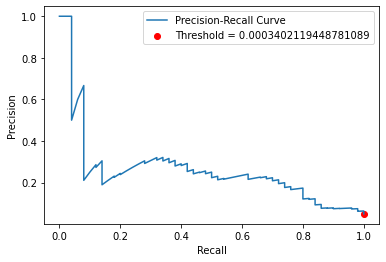

In [88]:
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.scatter(recall[threshold_index], precision[threshold_index], color='red', marker='o', label=f'Threshold = {chosen_threshold}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [ ]:
# work on editing threshold